annthyroid_21feat_normalised: round 0
Original training size: 921, No. outliers: 441
680 200 480 0
Training data size: 680, No. outliers: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        (None, 134)               0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                2700      
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 2,721
Trainable params: 2,721
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
20/20 [==============================] - 2s 88ms/step - loss: 2.8020
Epoch 2/20
20/20 [==============================] - 0s 2ms/step - loss: 2.7171
Epoch 3/20
20/20 [==============================] - 0s 2ms/step - loss: 2.6537
Epoch 4/20
20/20 [=

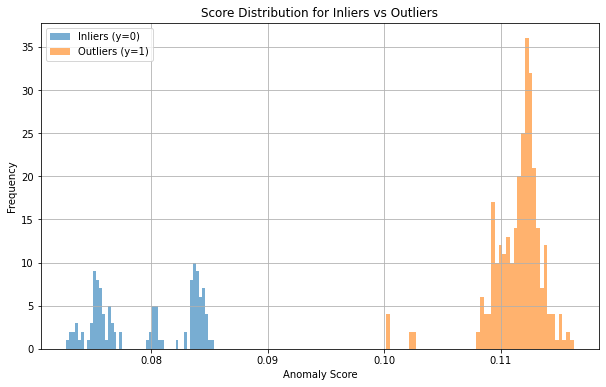

average AUC-ROC: 1.0000, average F1-score: 1.0000
average runtime: 5.2297 seconds


In [94]:
import numpy as np
np.random.seed(42)
# import tensorflow.compat.v1 as tf
import tensorflow as tf
# tf.disable_v2_behavior()
tf.set_random_seed(42)
sess = tf.Session()
import random
random.seed(45)

from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
#from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard

import argparse
import numpy as np
# import matplotlib.pyplot as plt
import sys
from scipy.sparse import vstack, csc_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import MinMaxScaler



import time
import pandas as pd

MAX_INT = np.iinfo(np.int32).max
data_format = 0

#tf.initialize_all_variables().run(session=sess)
init = tf.global_variables_initializer()
sess.run(init)

def dev_network_d(input_shape):
    '''
    deeper network architecture with three hidden layers
    '''
    x_input = Input(shape=input_shape)
    intermediate = Dense(1000, activation='relu',
                kernel_regularizer=regularizers.l2(0.01), name = 'hl1')(x_input)
    intermediate = Dense(250, activation='relu',
                kernel_regularizer=regularizers.l2(0.01), name = 'hl2')(intermediate)
    intermediate = Dense(20, activation='relu',
                kernel_regularizer=regularizers.l2(0.01), name = 'hl3')(intermediate)
    intermediate = Dense(1, activation='linear', name = 'score')(intermediate)
    return Model(x_input, intermediate)

def dev_network_s(input_shape):
    '''
    network architecture with one hidden layer
    '''
    x_input = Input(shape=input_shape)
    intermediate = Dense(20, activation='relu',
                kernel_regularizer=regularizers.l2(0.01), name = 'hl1')(x_input)
    intermediate = Dense(1, activation='linear',  name = 'score')(intermediate)
    return Model(x_input, intermediate)

def dev_network_linear(input_shape):
    '''
    network architecture with no hidden layer, equivalent to linear mapping from
    raw inputs to anomaly scores
    '''
    x_input = Input(shape=input_shape)
    intermediate = Dense(1, activation='linear',  name = 'score')(x_input)
    return Model(x_input, intermediate)

def deviation_loss(y_true, y_pred):
    '''
    z-score-based deviation loss
    '''
    confidence_margin = 5.
    ## size=5000 is the setting of l in algorithm 1 in the paper
    ref = K.variable(np.random.normal(loc = 0., scale= 1.0, size = 5000) , dtype='float32')
    dev = (y_pred - K.mean(ref)) / K.std(ref)
    inlier_loss = K.abs(dev)
    outlier_loss = K.abs(K.maximum(confidence_margin - dev, 0.))
    return K.mean((1 - y_true) * inlier_loss + y_true * outlier_loss)


def deviation_network(input_shape, network_depth):
    '''
    construct the deviation network-based detection model
    '''
    if network_depth == 4:
        model = dev_network_d(input_shape)
    elif network_depth == 2:
        model = dev_network_s(input_shape)
    elif network_depth == 1:
        model = dev_network_linear(input_shape)
    else:
        sys.exit("The network depth is not set properly")
    #rms = RMSprop(clipnorm=1.)
    rms = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss=deviation_loss, optimizer=rms)
    return model


def batch_generator_sup(x, outlier_indices, inlier_indices, batch_size, nb_batch, rng):
    """batch generator
    """
    rng = np.random.RandomState(rng.randint(MAX_INT, size = 1))
    counter = 0
    while 1:
        if data_format == 0:
            ref, training_labels = input_batch_generation_sup(x, outlier_indices, inlier_indices, batch_size, rng)
        else:
            ref, training_labels = input_batch_generation_sup_sparse(x, outlier_indices, inlier_indices, batch_size, rng)
        counter += 1
        yield(ref, training_labels)
        if (counter > nb_batch):
            counter = 0

def input_batch_generation_sup(x_train, outlier_indices, inlier_indices, batch_size, rng):
    '''
    batchs of samples. This is for csv data.
    Alternates between positive and negative pairs.
    '''
    dim = x_train.shape[1]
    ref = np.empty((batch_size, dim))
    training_labels = []
    n_inliers = len(inlier_indices)
    n_outliers = len(outlier_indices)
    for i in range(batch_size):
        if(i % 2 == 0):
            sid = rng.choice(n_inliers, 1)
            ref[i] = x_train[inlier_indices[sid]]
            training_labels += [0]
        else:
            sid = rng.choice(n_outliers, 1)
            ref[i] = x_train[outlier_indices[sid]]
            training_labels += [1]
    return np.array(ref), np.array(training_labels)


def input_batch_generation_sup_sparse(x_train, outlier_indices, inlier_indices, batch_size, rng):
    '''
    batchs of samples. This is for libsvm stored sparse data.
    Alternates between positive and negative pairs.
    '''
    ref = np.empty((batch_size))
    training_labels = []
    n_inliers = len(inlier_indices)
    n_outliers = len(outlier_indices)
    for i in range(batch_size):
        if(i % 2 == 0):
            sid = rng.choice(n_inliers, 1)
            ref[i] = inlier_indices[sid]
            training_labels += [0]
        else:
            sid = rng.choice(n_outliers, 1)
            ref[i] = outlier_indices[sid]
            training_labels += [1]
    ref = x_train[ref, :].toarray()
    return ref, np.array(training_labels)


def load_model_weight_predict(model_name, input_shape, network_depth, x_test):
    '''
    load the saved weights to make predictions
    '''
    model = deviation_network(input_shape, network_depth)
    model.load_weights(model_name)
    scoring_network = Model(inputs=model.input, outputs=model.output)

    if data_format == 0:
        scores = scoring_network.predict(x_test)
    else:
        data_size = x_test.shape[0]
        scores = np.zeros([data_size, 1])
        count = 512
        i = 0
        while i < data_size:
            subset = x_test[i:count].toarray()
            scores[i:count] = scoring_network.predict(subset)
            if i % 1024 == 0:
                print(i)
            i = count
            count += 512
            if count > data_size:
                count = data_size
        assert count == data_size
    return scores


def inject_noise_sparse(seed, n_out, random_seed):
    '''
    add anomalies to training data to replicate anomaly contaminated data sets.
    we randomly swape 5% features of anomalies to avoid duplicate contaminated anomalies.
    This is for sparse data.
    '''
    rng = np.random.RandomState(random_seed)
    n_sample, dim = seed.shape
    swap_ratio = 0.05
    n_swap_feat = int(swap_ratio * dim)
    seed = seed.tocsc()
    noise = csc_matrix((n_out, dim))
    print(noise.shape)
    for i in np.arange(n_out):
        outlier_idx = rng.choice(n_sample, 2, replace = False)
        o1 = seed[outlier_idx[0]]
        o2 = seed[outlier_idx[1]]
        swap_feats = rng.choice(dim, n_swap_feat, replace = False)
        noise[i] = o1.copy()
        noise[i, swap_feats] = o2[0, swap_feats]
    return noise.tocsr()

def inject_noise(seed, n_out, random_seed):
    '''
    add anomalies to training data to replicate anomaly contaminated data sets.
    we randomly swape 5% features of anomalies to avoid duplicate contaminated anomalies.
    this is for dense data
    '''
    rng = np.random.RandomState(random_seed)
    n_sample, dim = seed.shape
    swap_ratio = 0.05
    n_swap_feat = int(swap_ratio * dim)
    noise = np.empty((n_out, dim))
    for i in np.arange(n_out):
        outlier_idx = rng.choice(n_sample, 2, replace = False)
        o1 = seed[outlier_idx[0]]
        o2 = seed[outlier_idx[1]]
        swap_feats = rng.choice(dim, n_swap_feat, replace = False)
        noise[i] = o1.copy()
        noise[i, swap_feats] = o2[swap_feats]
    return noise

def aucPerformance(scores, labels):
    """
    Computes AUC-ROC and AUC-PR (Average Precision).
    scores: anomaly scores (higher = more anomalous)
    labels: ground-truth labels (0 = normal, 1 = outlier)
    """
    # Flatten arrays just in case
    scores = scores.reshape(-1)
    labels = labels.reshape(-1)

    auc = roc_auc_score(labels, scores)
    ap = average_precision_score(labels, scores)

    scores_inliers = scores[labels == 0]
    scores_outliers = scores[labels == 1]
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    
    plt.hist(scores_inliers, bins=50, alpha=0.6, label="Inliers (y=0)")
    plt.hist(scores_outliers, bins=50, alpha=0.6, label="Outliers (y=1)")
    
    plt.xlabel("Anomaly Score")
    plt.ylabel("Frequency")
    plt.title("Score Distribution for Inliers vs Outliers")
    plt.legend()
    plt.grid(True)
    plt.show()


    return auc, ap
    
def run_devnet(args):
    names = args.data_set.split(',')
    names = ['annthyroid_21feat_normalised']
    network_depth = int(args.network_depth)
    random_seed = args.ramdn_seed
    for nm in names:
        runs = args.runs
        rauc = np.zeros(runs)
        ap = np.zeros(runs)
        filename = nm.strip()
        # global data_format
        # data_format = int(args.data_format)
        # if data_format == 0:
        #     x, labels = dataLoading(args.input_path + filename + ".csv")
        # else:
        #     x, labels = get_data_from_svmlight_file(args.input_path + filename + ".svm")
        #     x = x.tocsr()
        # outlier_indices = np.where(labels == 1)[0]
        # outliers = x[outlier_indices]
        # n_outliers_org = outliers.shape[0]

        train_time = 0
        test_time = 0
        for i in np.arange(runs):
            
            x_train = np.load("x_train.npy")
            y_train = np.load("y_train.npy")
            y_train[y_train>0] = 1
            labels = y_train
            x_test = np.load("x_test.npy")
            y_test = np.load("y_test.npy")
            y_test[y_test>0] = 1



            scaler0 = MinMaxScaler()
            scaler0.fit(x_train)
            x_train = scaler0.transform(x_train)
            x_test = scaler0.transform(x_test)
            

            print(filename + ': round ' + str(i))
            outlier_indices = np.where(y_train == 1)[0]
            inlier_indices = np.where(y_train == 0)[0]
            n_outliers = len(outlier_indices)
            outliers = x_train[outlier_indices]
            print("Original training size: %d, No. outliers: %d" % (x_train.shape[0], n_outliers))

            n_noise  = len(np.where(y_train == 0)[0]) * args.cont_rate / (1. - args.cont_rate)
            n_noise = int(n_noise)

            rng = np.random.RandomState(random_seed)
            if data_format == 0:
                if n_outliers > args.known_outliers:
                    mn = n_outliers - args.known_outliers
                    remove_idx = rng.choice(outlier_indices, mn, replace=False)
                    x_train = np.delete(x_train, remove_idx, axis=0)
                    y_train = np.delete(y_train, remove_idx, axis=0)

                noises = inject_noise(outliers, n_noise, random_seed)
                x_train = np.append(x_train, noises, axis = 0)
                y_train = np.append(y_train, np.zeros((noises.shape[0], 1)))

            else:
                if n_outliers > args.known_outliers:
                    mn = n_outliers - args.known_outliers
                    remove_idx = rng.choice(outlier_indices, mn, replace=False)
                    retain_idx = set(np.arange(x_train.shape[0])) - set(remove_idx)
                    retain_idx = list(retain_idx)
                    x_train = x_train[retain_idx]
                    y_train = y_train[retain_idx]

                noises = inject_noise_sparse(outliers, n_noise, random_seed)
                x_train = vstack([x_train, noises])
                y_train = np.append(y_train, np.zeros((noises.shape[0], 1)))

            outlier_indices = np.where(y_train == 1)[0]
            inlier_indices = np.where(y_train == 0)[0]
            print(y_train.shape[0], outlier_indices.shape[0], inlier_indices.shape[0], n_noise)
            input_shape = x_train.shape[1:]
            n_samples_trn = x_train.shape[0]
            n_outliers = len(outlier_indices)
            print("Training data size: %d, No. outliers: %d" % (x_train.shape[0], n_outliers))


            start_time = time.time()
            input_shape = x_train.shape[1:]
            epochs = args.epochs
            batch_size = args.batch_size
            nb_batch = args.nb_batch
            model = deviation_network(input_shape, network_depth)
            print(model.summary())
            model_name = "./model/devnet_"  + filename + "_" + str(args.cont_rate) + "cr_"  + str(args.batch_size) +"bs_" + str(args.known_outliers) + "ko_" + str(network_depth) +"d.h5"
            #checkpointer = ModelCheckpoint(model_name, monitor='loss', verbose=0,
            #                              save_best_only = True, save_weights_only = True)
            output_data_shape = tf.TensorShape([batch_size, input_shape[0]])
            # The labels are scalar (0 or 1) per sample in a batch.
            output_label_shape = tf.TensorShape([batch_size])
            dataset = tf.data.Dataset.from_generator(
                lambda: batch_generator_sup(x_train, outlier_indices, inlier_indices, batch_size, nb_batch, rng),
                output_types=(tf.float32, tf.float32),
                output_shapes=(output_data_shape, output_label_shape)
            )

            model.fit(dataset, steps_per_epoch = nb_batch, epochs = epochs)
                                          #callbacks=[checkpointer])
            train_time += time.time() - start_time

            start_time = time.time()
            #scores = load_model_weight_predict(model_name, input_shape, network_depth, x_test)

            #model2 = deviation_network(input_shape, network_depth)
            #model2.load_weights(model)
            scoring_network = Model(inputs=model.input, outputs=model.output)

            if data_format == 0:
                scores = scoring_network.predict(x_test)
            else:
                data_size = x_test.shape[0]
                scores = np.zeros([data_size, 1])
                count = 512
                i = 0
                while i < data_size:
                    subset = x_test[i:count].toarray()
                    scores[i:count] = scoring_network.predict(subset)
                    if i % 1024 == 0:
                        print(i)
                    i = count
                    count += 512
                    if count > data_size:
                        count = data_size
                assert count == data_size
            
            test_time += time.time() - start_time
            rauc[i], ap[i] = aucPerformance(scores, y_test)

        mean_auc = np.mean(rauc)
        std_auc = np.std(rauc)
        mean_aucpr = np.mean(ap)
        std_aucpr = np.std(ap)
        train_time = train_time/runs
        test_time = test_time/runs
        print("average AUC-ROC: %.4f, average F1-score: %.4f" % (mean_auc, mean_aucpr))
        print("average runtime: %.4f seconds" % (train_time + test_time))

        #writeResults(filename+'_'+str(network_depth), x.shape[0], x.shape[1], n_samples_trn, n_outliers_org, n_outliers,
                     #network_depth, mean_auc, mean_aucpr, std_auc, std_aucpr, train_time, test_time, path=args.output)



parser = argparse.ArgumentParser()
parser.add_argument("--network_depth", choices=['1','2', '4'], default='2', help="the depth of the network architecture")
parser.add_argument("--batch_size", type=int, default=64, help="batch size used in SGD")
parser.add_argument("--nb_batch", type=int, default=20, help="the number of batches per epoch")
parser.add_argument("--epochs", type=int, default=20, help="the number of epochs")
parser.add_argument("--runs", type=int, default=1, help="how many times we repeat the experiments to obtain the average performance")
parser.add_argument("--known_outliers", type=int, default=200, help="the number of labeled outliers available at hand")
parser.add_argument("--cont_rate", type=float, default=0.00, help="the outlier contamination rate in the training data")
parser.add_argument("--input_path", type=str, default='/content/drive/My Drive/a1/', help="the path of the data sets")
parser.add_argument("--data_set", type=str, default='annthyroid_21feat_normalised', help="a list of data set names")
parser.add_argument("--data_format", choices=['0','1'], default='0',  help="specify whether the input data is a csv (0) or libsvm (1) data format")
parser.add_argument("--output", type=str, default='./results/devnet_auc_performance_30outliers_0.02contrate_2depth_10runs.csv', help="the output file path")
parser.add_argument("--ramdn_seed", type=int, default=42, help="the random seed number")
#args = parser.parse_args()
args, unknown = parser.parse_known_args()
#print("***********************")
#print(unknown)
#print("***********************")
#print(args)
run_devnet(args)